In [1]:
!pip install -q transformers datasets
from datasets import load_dataset
from huggingface_hub import notebook_login
notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.0 MB/s eta 0:00:00


In [2]:
import numpy as np
from datasets import load_dataset
dataset = load_dataset("LucasThil/randomized_clean_miniwob_episodes_v2")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/13412 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--randomized_clean_miniwob_episodes_v2-49501296fc0102ba/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
!git clone https://github.com/LucasStill/miniwob_zip.git

Cloning into 'miniwob_zip'...
remote: Enumerating objects: 24148, done.
remote: Counting objects: 100% (603/603), done.
remote: Compressing objects: 100% (601/601), done.
remote: Total 24148 (delta 3), reused 599 (delta 2), pack-reused 23545
Receiving objects: 100% (24148/24148), 411.46 MiB | 26.33 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (38067/38067), done.


In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 1 - Get out Tokenizer Class
css_fields = ['top', 'left', 'width', 'height']
special_characters = ['.', ',', '#', ':', '-', '/', '(', ')', 'https://', '@', '&', '"', "'", '!', '?', ';', '+', '=',
                      '*', '$', '€', '*', '`']


def round_to_nearest_ten(number):
    return round(number / 10) * 10

import torch
import torch.nn as nn


# Turn it into a class
class CCNeT5Tokenizer:
    def __init__(self, vocab_path):
        stoi = {}
        itos = {}
        self.padding_char = '<PAD>'
        self.special_characters = ['.', ',', '#', ':', '-', '/', '(', ')', 'https://', '@', '&', '"', "'", '!', '?',
                                   ';', '+', '=', '*', '$', '€', '*', '`']

        with open(vocab_path, 'r') as file:
            for index, line in enumerate(file):
                line = line.strip()
                stoi[line] = index
                itos[index] = line

        stoi[' '] = stoi['']
        itos[stoi[' ']] = ' '
        self.stoi = stoi
        self.stoi[self.padding_char] = len(stoi.keys())-1  # Add PADDING character
        # We do not need itos as we don't implement a de-tokinezing function.
        self.itos = itos
        self.itos[len(stoi.keys()) - 2] = self.padding_char  # Add PADDING character
        print(f'pad: {len(stoi.keys()) - 2}')
        print(f'Loaded CC_NeT5 Tokenizer with vocabulary size being {len(self.stoi)}.')

        # Instantiate the embedding function
        vocab_size = len(stoi)

    # Provide a string and tokenize it: utterance or task name.
    def tokenize_string(self, string):
        tokenized_string = []
        for w in str(string).lower().split(' '):
            for sc in self.special_characters:
                if sc in w:
                    w = w.replace(sc, 'Ø' + sc + 'Ø')
            p1_words = [s for s in w.split('Ø') if s != '']
            # Check if the found words exist in our vocab, else subdivide
            for fw in p1_words:
                if fw not in self.stoi.keys():
                    for c in fw:
                        tokenized_string.append(self.stoi[c])
                else:
                    tokenized_string.append(self.stoi[fw])
        return tokenized_string

    # Turns an array into a string
    def detokenize_array(self, array):
        reconstruted_string = []
        #pad_index = self.itos[self.stoi[self.padding_char]]
        for v in array:
            v = int(v)
            s = self.itos[v]
            if s != self.padding_char:
                reconstruted_string.append(s)

        #reconstruted_string = ' '.join(reconstruted_string)
        cleaned_string = ''
        last_single = False
        for s in reconstruted_string:
            if len(s) > 1:
                if last_single:
                    cleaned_string += ' '
                    last_single = False
                cleaned_string += s + ' '
            else:
                # We do this to treat single length characters
                cleaned_string += s
                last_single = True
        return cleaned_string

    # Truncate and pad the incoming sentences based on a max_size argument
    def truncate_pad_entry(self, tokenized_array, max_size):
        if len(tokenized_array) < max_size:
            while len(tokenized_array) < max_size:
                tokenized_array.append(self.stoi[self.padding_char])
            return tokenized_array
        elif len(tokenized_array) > max_size:
            # Too long, so we automatically truncate
            return tokenized_array[:max_size]
        else:
            # Just avoid iterating under the hood
            return tokenized_array

    # Tokenize a DOM dictionary
    def tokenize_dom(self, dom):
        tokenized_dom = []

        # Add opening tag
        element_tag = dom['tag'].lower()
        if 'input' in dom.keys():
            # if tag is input, reformat it
            element_tag = dom['input'].lower() + '_' + dom['type'].lower()
            tokenized_dom.append(self.stoi['<' + element_tag])
        else:
            # add normal tag
            tokenized_dom.append(self.stoi['<' + dom['tag'].lower()])

        for field in dom:
            if field != 'tag' and field != 'children' and field != 'type' and field != 'text' and field not in css_fields:  # and field != 'value':

                tokenized_dom.append(self.stoi[field.lower()])

                # Ensure we don't have float values, we'll stick with integers
                if isinstance(dom[field], float):
                    tokenized_dom.append(self.stoi[str(int(round_to_nearest_ten(dom[field])))])
                else:
                    words = str(dom[field]).lower().split(' ')
                    for word in words:
                        for sc in special_characters:
                            if sc in word:
                                word = word.replace(sc, 'Ø' + sc + 'Ø')
                        p1_words = [s for s in word.split('Ø') if s != '']

                        # decides whether we keep the full word, or just the letters:
                        if field == 'value' or (False and (field == 'label' or field == 'button')):
                            for w in p1_words:
                                # Take individual characters of the value string
                                processed_words = [self.stoi[w[i:i + 1]] for i in range(0, len(w), 1)]
                                tokenized_dom += processed_words

                        elif field == 'ref':
                            for w in p1_words:
                                # Take individual characters of the value string
                                processed_words = [self.stoi[w[i:i + 3]] for i in range(0, len(w), 3)]
                                tokenized_dom += processed_words
                        else:
                            # Use the full word:
                            for w in p1_words:
                                tokenized_dom.append(self.stoi[str(w)])

            elif field == 'text':
                tokenized_dom.append(self.stoi['text'])
                for c in dom[field]:
                    tokenized_dom.append(self.stoi[c])
            elif field in css_fields:
                # Cast field
                tokenized_dom.append(self.stoi[field])
                css_value = int(round_to_nearest_ten(float(dom[field])))
                tokenized_dom.append(self.stoi[str(css_value)])

        if 'children' in dom.keys():
            tokenized_dom.append(self.stoi['children'])
            for child in dom['children']:
                tokenized_dom += self.tokenize_dom(child)
                # for v in found_vocab:
                #    tokenized_dom.append(self.stoi[v])

        # add closing tag
        tokenized_dom.append(self.stoi['</' + element_tag + '>'])

        return tokenized_dom

vocab_path="/content/drive/MyDrive/WebAI/Notebooks/CC_NeT5/vocab.txt"
tokenizer = CCNeT5Tokenizer(vocab_path=vocab_path)

pad: 1590
Loaded CC_NeT5 Tokenizer with vocabulary size being 1592.


In [6]:


# Load some of the images we have here and try to save them to the dataset
import os
from typing import List, Tuple
import numpy as np
from PIL import Image
import torch
import pandas as pd
import re
import json
from torch.utils.data import DataLoader
import random

class DatasetLoader:
    #def __init__(self, screenshots_path, dataset, start_index, end_index, dom_tokenizer, batch_size):
    def __init__(self, screenshots_path, dataset, dom_tokenizer, batch_size):

        # Get the Subset of the dataset
        #self.start_index = start_index
        #self.end_index = end_index
        self.df = dataset['train'].to_pandas()##[self.start_index:self.end_index]
        # When creating the class, parse JSON files into a state-based list structure
        self.df['processed_states'] = self.df['processed_states'].apply(lambda x: json.loads(re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), x.replace("'", '"'))))
        print(f'Dataset subset has {len(self.df)} rows')

        self.screenshots_path = screenshots_path
        # If want to load them from the directory
        self.indices, found_screenshots = self.get_file_indices()
        # Or load the previously saved indices
        #self.indices = self.read_indices_from_file('/content/drive/MyDrive/WebAI/file_indices.txt')
        found_screenshots = len(self.indices)
        print(f'Found a total of {found_screenshots} state screenshots for {len(self.indices)} episodes.')

        # Load all images from the drive
        #self.add_images_to_episodes()
        # Load N samples

        self.dom_tokenizer = dom_tokenizer
        self.dom_seq_length = 492
        self.utterance_seq_length = 16
        self.task_name_seq_length = 4

        self.target_action_type_seq_length = 1
        self.target_ref_seq_length = 1
        self.target_keydown_seq_length = 8 #32

        # Size of the final layer output being composed of
        # 1 (action),
        # + 64 (ref) (
        # + 64x8 (keydown text times target_keydown_seq_length)
        self.model_output_size = 577

        self.batch_size = batch_size

    # Add the images to the different episodes of the dataset
    def add_images_to_episodes_old(self):
        found_images = []
        i = self.start_index
        image_counter = 0
        while i < self.end_index:
            if i % 100 == 0:
              print(f'Done: {i}')
            # Get K indices
            images = []
            try:
              state_indexes = self.indices[i]
              for state_index in state_indexes:
                  images.append(self.read_image(i, state_index))
                  image_counter += 1
              found_images.append(images)
            except:
              print(f'error {i}')
            i += 1
        # Add new column
        self.df['episode_images'] = found_images
        print(f'Found total of {image_counter} images in the loaded episodes.')

    # Load the images in batches
    def add_images_to_episodes(self):
      found_images = []
      image_counter = 0

      for i in range(self.start_index, self.end_index):
        if i%100 == 0:
          print(f'Done :{i}')
        try:
            state_indexes = self.indices[i]
            images = [self.read_image(i, state_index) for state_index in state_indexes]
            found_images.append(images)
            image_counter += len(images)
        except Exception as e:
            print(f'Error at index {i}: {str(e)}')
            # FFUUUCK NEED TO DO SOMETHING HERE IF ERROR...
            state_indexes = self.indices[i]
            for state_index in state_indexes:
              try:
                images.append(self.read_image(i, state_index))
                image_counter += 1
              except:
                'ehhh'
            found_images.append(images)


      self.df['episode_images'] = found_images
      print(f'Found a total of {image_counter} images in the loaded episodes.')


    def get_file_indices(self) -> List[Tuple[int, int]]:
        indices = []
        for filename in os.listdir(self.screenshots_path):
            if filename.endswith('.png'):
                # Extract the N and K values from the filename
                N, K = filename.replace('sc_', '').replace('st_', '').replace('.png', '').split('_')
                N = int(N)
                K = int(K)
                indices.append((N, K))

        # Turn the indices into a dictionary
        indices_dict = {}
        for (N, K) in indices:
            if N not in indices_dict:
                indices_dict[N] = [K]
            else:
                indices_dict[N].append(K)
                indices_dict[N] = sorted(indices_dict[N])

        return indices_dict, len(indices)

    def save_file_indices_to_file(self, dictionary, filename):
      with open(filename, 'w') as file:
          for key, value in dictionary.items():
              line = f"{key}: {value}\n"
              file.write(line)

    def read_indices_from_file(self, filename):
        dictionary = {}
        with open(filename, 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                key = int(key)
                value = [int(num) for num in value.strip('[]').split(', ')]
                dictionary[key] = value
        return dictionary

    import torch

    # Reads images into tensor
    def read_image_old(self, N, K) -> torch.Tensor:
        filename = f'sc_{N}_st_{K}.png'
        filepath = os.path.join(self.screenshots_path, filename)
        image = Image.open(filepath).convert('RGB')
        tensor = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255.0
        return tensor

    # Pure NP instead of tensor
    def read_image(self, N, K) -> np.array:
        filename = f'sc_{N}_st_{K}.png'
        filepath = os.path.join(self.screenshots_path, filename)
        image = Image.open(filepath).convert('RGB')
        array = np.transpose(np.array(image) / 255.0, (2, 0, 1))
        return array


    def save_image_png(self, N, K):
        loaded_image = self.read_image(N, K).numpy()
        print(f'Image has shape {loaded_image.shape}')

        # scale the pixel values from [0,1] to [0, 255]
        array = np.clip(loaded_image * 255, 0, 255).astype('uint8')
        img = Image.fromarray(array.transpose(1, 2, 0), mode='RGB')
        img.save('screenshots/test_img.png')

    # Turn our dataset into a series of state tensors ready for training.
    # We though ensure to clearly separate our different instances:
    # - todo: T5-Data (for later, depends between SL or RL current approach)
    # - RBG
    # - todo: Tokenized DOM
    # - todo: Task Instruction
    # They are separated because they are not going to be fed in the same manner into the model.
    # Basically into one single row.
    # todo: skip rows that have negative rewards
    def process_dataset(self):
        rbg_data = []
        dom_data = []
        utterance_data = []
        task_name_data = []

        target_action = []
        target_refs = []
        target_keydown = []

        episode_previous_actions = []

        # Some metrics
        duplicated_images = 0
        cut_images = 0

        for (index, row) in self.df.iterrows():
            if float(row['reward']) <= 0: # Skips failed episodes
                continue
            if len(row['episode_images']) != len(row['processed_states']): # Skips episodes with no matching pictures amount and states
                len_processed_states = len(row['processed_states'])
                len_episode_images = len(row['episode_images'])
                print(f'Error: episode_images and processed_states don\' have the same length for index {index}: len_episode_images={len_episode_images}, len_processed_states={len_processed_states}')
                # We just discard it, fuck it if it's just an individual row and only one image missing out of n states.
                # Data processing showed that only few states were missing from the zip and got fixed except a couple of them

                # Ok actually fix it by cloning the last rgb
                if len_episode_images < len_processed_states:
                  last_img = row['episode_images'][len(row['episode_images'])-1]
                  while len(row['episode_images']) < len_processed_states:
                    row['episode_images'].append(last_img)
                    duplicated_images += 1
                else:
                  # Too few processed states for pictures, cut last pic.
                  # We keep the processed states over the generated screenshots
                  row['episode_images'] = row['episode_images'][:len_processed_states]
                  cut_images += len_episode_images - len_processed_states
                #continue
            for rbg in row['episode_images']:
                rbg = np.array(rbg, dtype='float64')
                #print(f'rbg shape: {rbg.shape}')
                rbg_data.append(rbg)


            # Process DOM Data
            for (index_state, state) in enumerate(row['processed_states']):

                # Output Tokens
                if state['action_type'] == 'click': # Append boolean for action click or keydown
                    t_action = np.array([0])
                    target_action.append(t_action)
                else:
                    t_action = np.array([1])
                    target_action.append(t_action)

                # Tokenize ref and appends to target
                #sr = state['refs']
                #print(f'state ref: {sr})
                t_ref = np.array(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(str(state['refs'])), self.target_ref_seq_length))
                target_refs.append(t_ref)
                # Tokenize target text and appends to target
                t_keydown = np.array(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(state['keydown_text']), self.target_keydown_seq_length))
                target_keydown.append(t_keydown)

                # Input Tokens
                # Tokenize dom
                tokenized_dom = self.dom_tokenizer.tokenize_dom(state['dom'])
                tokenized_dom = self.dom_tokenizer.truncate_pad_entry(tokenized_dom, self.dom_seq_length)
                dom_data.append(tokenized_dom)

                # Tokenize utterance
                tokenized_utterance = self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(row['utterance']), self.utterance_seq_length)
                utterance_data.append(tokenized_utterance)

                # Tokenize task name
                tokenized_task_name = self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(row['task_name']), self.task_name_seq_length)
                task_name_data.append(tokenized_task_name)

                # Deal with the previous action
                if index_state < len(row['processed_states'])-1:
                    # Default one so empty for the first action
                    if index_state == 0:
                        episode_previous_actions.append([])
                        #episode_previous_actions.append(self.dom_tokenizer.truncate_pad_entry(self.dom_tokenizer.tokenize_string(''), self.model_output_size))

                    # Add previous actions one by one
                    episode_previous_actions.append([t_action, t_ref, t_keydown])
                elif index_state >= len(row['processed_states'])-1 and index_state == 0:
                    episode_previous_actions.append([])
                # Else no action to add




        rbg_data = np.stack(rbg_data)
        dom_data = np.array(dom_data)
        utterance_data = np.array(utterance_data)
        task_name_data = np.array(task_name_data)
        target_action = np.array(target_action)
        target_refs = np.array(target_refs)
        target_keydown = np.array(target_keydown)

        print(f'duplicated_images: {duplicated_images}, cut_images: {cut_images}')

        return rbg_data, dom_data, utterance_data, task_name_data, target_action, target_refs, target_keydown, episode_previous_actions


    # Batchify the dataset
    def get_dataloder(self, dataset):
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return train_loader

    # Creates random indexes to split and shuffle the test and training datasets
    def create_train_test_dataset(self, length):
        # Calculate the number of random indexes (10% of length)
        num_random_indexes = int(length * 0.1)

        # Generate random indexes without replacement
        random_indexes = random.sample(range(length), num_random_indexes)

        # Create train and test datasets
        train_dataset = []
        test_dataset = []

        for i in range(length):
            if i in random_indexes:
                test_dataset.append(i)
            else:
                train_dataset.append(i)

        # Shuffle the train and test datasets
        random.shuffle(train_dataset)
        random.shuffle(test_dataset)

        return train_dataset, test_dataset

    # Devise datasets
    def split_datasets(self, rbg_data, dom_data, utterance_data, task_name_data, target_action, target_refs, target_keydown, episode_previous_actions):
        train_indexes, test_indexes = self.create_train_test_dataset(length=len(rbg_data))

        train_rgb = rbg_data[train_indexes]
        train_dom = dom_data[train_indexes]
        train_utterance = utterance_data[train_indexes]
        train_task_name = task_name_data[train_indexes]
        train_target_action = target_action[train_indexes]
        train_target_ref = target_refs[train_indexes]
        train_target_keydown = target_keydown[train_indexes]
        train_episode_previous_action = []
        for index in train_indexes:
            train_episode_previous_action.append(episode_previous_actions[index])

        # Create a boolean mask of the indexes
        test_rgb = rbg_data[test_indexes]
        test_dom = dom_data[test_indexes]
        test_utterance = utterance_data[test_indexes]
        test_task_name = task_name_data[test_indexes]
        test_target_action = target_action[test_indexes]
        test_target_ref = target_refs[test_indexes]
        test_target_keydown = target_keydown[test_indexes]
        test_episode_previous_action = []
        for index in test_indexes:
            test_episode_previous_action.append(episode_previous_actions[index])

        return train_rgb, train_dom, train_utterance, train_task_name, train_target_action, train_target_ref, \
               train_target_keydown, train_episode_previous_action, test_rgb, test_dom, test_utterance, \
               test_task_name, test_target_action, test_target_ref, test_target_keydown, test_episode_previous_action

    # Get a dictionary with each task name, load N samples per task
    def get_predefined_indices(self, path, N, dataset):
      def load_dictionary_from_file(file_path):
        with open(file_path, 'r') as file:
            dictionary = json.load(file)
            return dictionary
      dict_tasks = load_dictionary_from_file(path)
      print(dict_tasks)

      import random

      def sample_N(x, N):
        if len(x) < N:
          return x
        return random.sample(x, N)

      downsampled_tasks = {}
      downsampled_tasks_counts = {}
      total_counts = 0
      for key, value in dict_tasks.items():
        samples = sample_N(value, N)
        total_counts += len(samples)
        downsampled_tasks[key] = sorted(samples)
        downsampled_tasks_counts[key] = len(samples)

      print(f'Got total downsampled_tasks_counts: {total_counts}')
      print(f'downsampled_tasks: {downsampled_tasks}')

      # Put them into a single list
      indices = []
      for key, samples in downsampled_tasks.items():
        #print(f'samples: {samples}')
        indices += samples
      indices = sorted(indices)
      print(f'found indices: {indices}')
      print(f'self indices: {self.indices}')

      # Now load corresponding K values for RGB data from the original loaded indices
      indices_to_load = {}
      failed_sample_indexes = []
      for index in indices:
        try:
          samples = self.indices[index]
          #if index not in indices_to_load.keys():
            #indices_to_load[index] = []
          indices_to_load[index] = samples
        except Exception as e:
          print(f'Could not load samples at index {index}: {e}')
          failed_sample_indexes.append(index)
      print(f'failed_sample_indexes: {failed_sample_indexes}')

      found_images = []
      image_counter = 0
      # Now load RGB pictures
      i = 0

      # List our indices in order:
      ordered_indices = sorted(indices_to_load.keys())
      print(f'indices_to_load: {indices_to_load}')
      print(f'ordered_indices: {ordered_indices}')

      for row_index in ordered_indices:
        state_indexes = indices_to_load[row_index]
        #print(f'state_indexes: {row_index}-{state_indexes}')
        if i % 50 == 0:
          print(f'Done: {i}')
        loaded_images_episode = 0
        episode_images = []

        try:
          images = [self.read_image(row_index, state_index) for state_index in state_indexes]
          image_counter += len(images)
          loaded_images_episode += len(images)
          episode_images = images
        except Exception as e:
          episode_images = []
          print(f'Error at index {i}: {str(e)}')
          # FFUUUCK NEED TO DO SOMETHING HERE IF ERROR...
          for state_index in state_indexes:
            try:
              episode_images.append(self.read_image(row_index, state_index))
              image_counter += 1
              loaded_images_episode += 1
            except:
              'ehhh'
        found_images.append(episode_images)
        if loaded_images_episode != len(state_indexes):
          print(f'Not same length loaded_images_episode: {loaded_images_episode} - {len(state_indexes)} for index {row_index}')
        if len(episode_images) != len(state_indexes):
          print(f'Not same length episode_images: {len(episode_images)} - {len(state_indexes)} for index {row_index}')

        i += 1


      print(f'Found a total of {image_counter} images in the loaded episodes.')


      # Reformat our self.df with the selected rows
      self.df = dataset.iloc[ordered_indices]
      # When creating the class, parse JSON files into a state-based list structure
      self.df['processed_states'] = self.df['processed_states'].apply(lambda x: json.loads(re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), x.replace("'", '"'))))
      print(f'Dataset subset sampled has {len(self.df)} rows')
      print(f'found_images for total episodes: {len(found_images)}')
      self.df.loc[:, 'episode_images'] = found_images

In [ ]:
#del dataset_loader

In [7]:
#screenshots_path = '/content/drive/MyDrive/WebAI/screenshot_indexes'
#screenshots_path = '/content/sample_data_screenshots'
screenshots_path = '/content/miniwob_zip'
batch_size = 8
# NOTE!!!: Check if need to rerun the indices on all pictures instead of range
#dataset_loader = DatasetLoader(screenshots_path=screenshots_path, dataset=dataset, start_index=0, end_index=20, dom_tokenizer=tokenizer, batch_size=batch_size)
dataset_loader = DatasetLoader(screenshots_path=screenshots_path, dataset=dataset, dom_tokenizer=tokenizer, batch_size=batch_size)

Dataset subset has 13412 rows
Found a total of 9184 state screenshots for 9184 episodes.


In [8]:
dataset_loader.get_predefined_indices('/content/drive/MyDrive/WebAI/Configs/indices_dictionary2.json', 150, dataset['train'].to_pandas())

{'email-inbox-nl-turk': [0, 4, 6, 7, 10, 11, 16, 22, 23, 24, 26, 27, 29, 31, 34, 39, 42, 44, 45, 47, 48, 49, 52, 53, 59, 65, 67, 70, 71, 73, 78, 85, 92, 94, 96, 97, 104, 105, 108, 109, 110, 111, 112, 114, 124, 127, 131, 132, 133, 136, 137, 138, 139, 141, 144, 145, 156, 162, 163, 164, 167, 171, 172, 173, 174, 179, 181, 187, 190, 191, 194, 195, 200, 206, 207, 209, 210, 214, 215, 216, 217, 220, 221, 222, 224, 225, 228, 229, 234, 239, 243, 244, 245, 249, 254, 256, 258, 259, 260, 261, 263, 266, 269, 270, 271, 276, 277, 282, 284, 285, 286, 288, 289, 292, 293, 294, 298, 302, 303, 308, 312, 314, 321, 323, 327, 336, 342, 346, 347, 350, 351, 356, 362, 365, 374, 375, 376, 377, 378, 379, 380, 381, 385, 387, 390, 391, 392, 396, 397, 398, 402, 403, 408, 411, 412, 413, 414, 415, 418, 420, 425, 426, 432, 433, 440, 441, 445, 450, 451, 452, 453, 459, 465, 466, 468, 470, 472, 473, 475, 478, 479, 483, 487, 488, 489, 490, 491, 497, 500, 501, 506, 507, 512, 517, 519, 522, 523, 524, 525, 526, 530, 539, 544, 

<ipython-input-6-ef4418647d6a>:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['processed_states'] = self.df['processed_states'].apply(lambda x: json.loads(re.sub(r'\b(True|False)\b', lambda m: m.group(0).lower(), x.replace("'", '"'))))
<ipython-input-6-ef4418647d6a>:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.loc[:, 'episode_images'] = found_images


In [9]:
dataset_loader.df.head()

,task_name,utterance,reward,raw_reward,processed_states,episode_images
4,email-inbox-nl-turk,Find Cynthia's e-mail and reply with the words...,0.500667,1.0,"[{'time': 12847, 'action_type': 'keypress', 'd...",[[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
6,email-inbox-nl-turk,Find Aryn's email and send it to Agnes.,0.687400,1.0,"[{'time': 6957, 'action_type': 'click', 'dom':...",[[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
7,email-inbox-nl-turk,"reply to Pammy's last email ""Non.""",0.364733,1.0,"[{'time': 18032, 'action_type': 'click', 'dom'...",[[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
10,email-inbox-nl-turk,The email that is found in the email app and w...,0.359733,1.0,"[{'time': 11526, 'action_type': 'click', 'dom'...",[[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
11,email-inbox-nl-turk,"Find Sheila's email, forward to Ariel",0.656100,1.0,"[{'time': 6916, 'action_type': 'click', 'dom':...",[[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...


In [ ]:
i = 0
for index, row in dataset_loader.df.iterrows():
  print(f'{index}, {len(row["processed_states"])} - {len(row["episode_images"])}')
  if i > 10:
    break
  i += 1

0, 3 - 3
4, 2 - 1
6, 3 - 4
10, 3 - 3
22, 3 - 3
23, 1 - 1
24, 3 - 3
29, 3 - 3
31, 3 - 3
44, 3 - 3
45, 3 - 3
47, 3 - 3


In [ ]:
len(list(set(list(dataset_loader.indices.keys()))))

9184

In [ ]:
len(dataset_loader.df)

2443

In [10]:
rgb_data, dom_data, utterance_data, task_data, target_action, target_refs, target_keydown, episode_previous_actions = dataset_loader.process_dataset()

Error: episode_images and processed_states don' have the same length for index 4: len_episode_images=1, len_processed_states=2
Error: episode_images and processed_states don' have the same length for index 6: len_episode_images=4, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 26: len_episode_images=1, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 110: len_episode_images=1, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 124: len_episode_images=1, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 167: len_episode_images=1, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 342: len_episode_images=1, len_processed_states=3
Error: episode_images and processed_states don' have the same length for index 377: len_episode_images

In [11]:
len(rgb_data), len(dom_data), len(utterance_data), len(task_data), len(target_action), len(target_refs), len(target_keydown), len(episode_previous_actions)

(9417, 9417, 9417, 9417, 9417, 9417, 9417, 9417)

In [12]:

# Create Train/Test Splits
train_rgb, train_dom, train_utterance, train_task_name, train_target_action, train_target_ref, \
               train_target_keydown, train_episode_previous_action, test_rgb, test_dom, test_utterance, test_task_name, test_target_action, \
               test_target_ref, test_target_keydown, test_episode_previous_action = dataset_loader.split_datasets(rgb_data, dom_data, utterance_data, task_data, target_action, target_refs, target_keydown, episode_previous_actions)

train_rgb.shape, train_dom.shape, train_utterance.shape, train_task_name.shape, train_target_action.shape, train_target_ref.shape, \
               train_target_keydown.shape, \
test_rgb.shape, test_dom.shape, test_utterance.shape, test_task_name.shape, test_target_action.shape, test_target_ref.shape, \
    test_target_keydown.shape


((8476, 3, 210, 160),
 (8476, 492),
 (8476, 16),
 (8476, 4),
 (8476, 1),
 (8476, 1),
 (8476, 8),
 (941, 3, 210, 160),
 (941, 492),
 (941, 16),
 (941, 4),
 (941, 1),
 (941, 1),
 (941, 8))

In [13]:

import numpy as np
import torch

def format_language_rgb_input(rgb_data, dom_data, utterance_data, task_data):
    # Put language task together
    language_input = np.concatenate((dom_data, utterance_data, task_data), axis=1)
    #language_input = dom_data
    print(language_input.shape)

    rgb_data = torch.from_numpy(rgb_data).type(torch.float32)
    language_input = torch.from_numpy(language_input).type(torch.long)

    #NO EMBEDDINGS, REMOVED
    #language_input = tokenizer.embedding_fn(language_input) # Create embeddings for language
    print(f'rgb_data: {rgb_data.shape}, language_input: {language_input.shape}')
    return rgb_data, language_input

train_rgb_data, train_language_input = format_language_rgb_input(rgb_data=train_rgb, dom_data=train_dom, utterance_data=train_utterance, task_data=train_task_name)
test_rgb_data, test_language_input = format_language_rgb_input(rgb_data=test_rgb, dom_data=test_dom, utterance_data=test_utterance, task_data=test_task_name)


(8476, 512)
rgb_data: torch.Size([8476, 3, 210, 160]), language_input: torch.Size([8476, 512])
(941, 512)
rgb_data: torch.Size([941, 3, 210, 160]), language_input: torch.Size([941, 512])


In [33]:
# IMPORTANT CHANGES: target output is size 10 which is (action type+1)(ref=1)(keydown=8)
# this is without embeddings this time, only tokens

# Test formatting of previous action sequence data.
# TODO: need to update the dataloader with them
def format_previous_actions(episode_previous_actions, tokenizer, dataset_loader):
    formatted_previous_actions = []

    # Process one by one the different entries to have them correctly matching the dataset
    for entry in episode_previous_actions:
        # No previous action, have default empty sequence
        if len(entry) == 0:
            empty_action = np.array(tokenizer.truncate_pad_entry(tokenizer.tokenize_string(''), 10))
            #empty_action = np.array(tokenizer.tokenize_string('')*10)
            formatted_previous_actions.append(empty_action)
        else:
            action_type = torch.from_numpy(entry[0]).type(torch.long)
            ref = torch.from_numpy(entry[1]).type(torch.long)
            # REMOVED EMBEDDING
            #ref = torch.flatten(tokenizer.embedding_fn(ref))
            #ref = torch.flatten(ref)
            # REMOVED EMBEDDING
            #keydown = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(entry[2]).type(torch.long)))
            #keydown = torch.flatten().type(torch.long))
            keydown = torch.from_numpy(entry[2])
            together = np.concatenate((action_type.detach().numpy(), ref.detach().numpy(), keydown.detach().numpy()))
            formatted_previous_actions.append(together)

    formatted_previous_actions = np.array(formatted_previous_actions, dtype=np.int64)
    return formatted_previous_actions

# These are the formatted actions to use when concatenating after the multimodal layers.
train_formatted_previous_actions = format_previous_actions(episode_previous_actions=train_episode_previous_action, tokenizer=tokenizer, dataset_loader=dataset_loader)
print(f'Got TRAIN {len(train_formatted_previous_actions)} formatted_previous_actions, type: {train_formatted_previous_actions.dtype}')
# into tensor
train_formatted_previous_actions = torch.from_numpy(train_formatted_previous_actions)
print(f'formatted_previous_actions: {train_formatted_previous_actions.shape}, {train_formatted_previous_actions.dtype}')

# These are the formatted actions to use when concatenating after the multimodal layers.
test_formatted_previous_actions = format_previous_actions(episode_previous_actions=test_episode_previous_action, tokenizer=tokenizer, dataset_loader=dataset_loader)
print(f'Got TEST {len(test_formatted_previous_actions)} formatted_previous_actions, type: {test_formatted_previous_actions.dtype}')
# into tensor
test_formatted_previous_actions = torch.from_numpy(test_formatted_previous_actions)
print(f'formatted_previous_actions: {test_formatted_previous_actions.shape}, {test_formatted_previous_actions.dtype}')


Got TRAIN 8476 formatted_previous_actions, type: int64
formatted_previous_actions: torch.Size([8476, 10]), torch.int64
Got TEST 941 formatted_previous_actions, type: int64
formatted_previous_actions: torch.Size([941, 10]), torch.int64


In [34]:
# IMPORTANT CHANGES: REMOVED EMBEDDINGS, ONLY TOKENS

# Produces target labels.
# TODO: also use it to format the T5 output text to feed CC-NeT5
def produce_labels(target_action, target_refs, target_keydown):
    i = 0
    labels = []

    while i<len(target_action):
        # Tokenize refs and keydowns
        action = torch.from_numpy(target_action[i]).detach().numpy()
        #embedded_ref = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(target_refs[i]))).detach().numpy()
        ref = torch.from_numpy(target_refs[i])
        #embedded_keydown = torch.flatten(tokenizer.embedding_fn(torch.from_numpy(target_keydown[i]))).detach().numpy()
        keydown = torch.from_numpy(target_keydown[i])

        label = np.concatenate((action, ref, keydown), axis=0)
        labels.append(label)
        i += 1

    labels = np.array(labels)
    labels = torch.from_numpy(labels).type(torch.float32)
    return labels

train_labels = produce_labels(train_target_action, train_target_ref, train_target_keydown)
test_labels = produce_labels(test_target_action, test_target_ref, test_target_keydown)
train_labels.shape, test_labels.shape


(torch.Size([8476, 10]), torch.Size([941, 10]))

In [35]:
# Batchify data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#batched_rgb = dataset_loader.get_dataloder(dataset=rgb_data.to(torch.device(device)))
#batched_language = dataset_loader.get_dataloder(dataset=language_input.to(torch.device(device)))
#batched_previous_actions = dataset_loader.get_dataloder(dataset=formatted_previous_actions.to(torch.device(device)))
#batched_labels = dataset_loader.get_dataloder(dataset=labels.to(torch.device(device)))

# Batchify data
train_batched_rgb = dataset_loader.get_dataloder(dataset=train_rgb_data.to(torch.device(device)))
train_batched_language = dataset_loader.get_dataloder(dataset=train_language_input.to(torch.device(device)))
train_batched_previous_actions = dataset_loader.get_dataloder(dataset=train_formatted_previous_actions.to(torch.device(device)))
train_batched_labels = dataset_loader.get_dataloder(dataset=train_labels.to(torch.device(device)))

test_batched_rgb = dataset_loader.get_dataloder(dataset=test_rgb_data.to(torch.device(device)))
test_batched_language = dataset_loader.get_dataloder(dataset=test_language_input.to(torch.device(device)))
test_batched_previous_actions = dataset_loader.get_dataloder(dataset=test_formatted_previous_actions.to(torch.device(device)))
test_batched_labels = dataset_loader.get_dataloder(dataset=test_labels.to(torch.device(device)))


In [40]:
for entry in train_batched_previous_actions:
  print(entry.shape)
  break

torch.Size([8, 10])


In [36]:

# Some model classes

'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3),
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=14):
        super(ResNet, self).__init__()
        self.in_planes = 3

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        #out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(x)
        dl1 = out.shape
        out = self.layer2(out)
        dl2 = out.shape
        out = self.layer3(out)
        dl3 = out.shape
        out = self.layer4(out)
        dl4 = out.shape
        #out = F.avg_pool2d(out, 4)
        #out = out.view(out.size(0), -1)

        # Flatten (batch size, channels, features)
        out = out.view(batch_size, 512, 140)
        out_1_s = out.shape
        # Might have to change the last layer to obtain our 14x11 feature vector?
        #out = self.linear(out)
        #print(f'out_1_s: {out_1_s}, out: {out.shape}')
        #print(f'dl1: {dl1}, dl2: {dl2}, dl3: {dl3}, dl4: {dl4}, out: {out_1_s}')
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# ----------------------------------
# Cross Attention Model for Language
class CrossAttentionModelLanguage(nn.Module):
    # Bigger2: Changed hidden_dim from 140 to 1
    def __init__(self, input_dim=64, hidden_dim=140, num_heads=4):
        super(CrossAttentionModelLanguage, self).__init__()

        self.attention = nn.MultiheadAttention(input_dim, num_heads)
        self.linear = nn.Linear(input_dim, hidden_dim)

    def forward(self, input):
        # Reshape the input to (sequence_length, batch_size, input_dim)
        input = input.permute(1, 0, 2)

        # Apply cross-attention
        output, _ = self.attention(input, input, input)

        # Reshape the output to (batch_size, sequence_length, input_dim)
        output = output.permute(1, 0, 2)

        # Apply linear transformation
        output = self.linear(output)

        return output


#--------------------------------
# Multimodal Transformer Network
from torch.nn import Transformer

class TransformerNetwork(nn.Module):
    def __init__(self):
        super(TransformerNetwork, self).__init__()

        self.embedding_dim = 512
        self.num_layers = 8
        self.num_heads = 8

        # Bigger2: 512, self.embedding_dim)# version1: 141
        self.embedding = nn.Linear(512, self.embedding_dim)
        self.transformer = Transformer(
            d_model=self.embedding_dim,
            nhead=self.num_heads,
            num_encoder_layers=self.num_layers,
            num_decoder_layers=self.num_layers
        )
        #self.output_layer = nn.Linear(self.embedding_dim, 1)

    def forward(self, input_tensor):
        batch_size = input_tensor.size(0)

        embedded = self.embedding(input_tensor)
        embedded = embedded.permute(1, 0, 2)

        output = self.transformer(embedded, embedded)
        output = output.permute(1, 0, 2)
        #output = self.output_layer(output)

        return output.squeeze(2)

#-------------------
# LSTM Netowkr Part
class TwoLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TwoLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Note: we use a Linear layer for dimension adjustment.
        # Indeed, the previous multi-modal transformer outputs a 1024 + prev_action length tensor,
        # and here the LSTM layers have a 512 dim where we also need to bypass residual connections.
        # We use the linear layer below to have a matching size with the input/output of these LSTMs
        # in order to concatenate them.
        self.linear = nn.Linear(input_size, hidden_size)

        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)

        # This linear layer is for the final mapping
        #self.fc = nn.Linear(hidden_size, output_size) #fully connected last layer

    def forward(self, input):
        # Perform dimension adjustment using the linear layer
        adjusted_input = self.linear(input)
        #print(f'adjusted_input: {adjusted_input.shape}')

        # Perform the forward pass through each LSTM layer
        output, _hidden_state = self.lstm(adjusted_input)

        # Perform residual connections between LSTM layers
        residual_output = adjusted_input + output

        # Extract the hidden state of the last LSTM layer after residual connections
        last_hidden_state = residual_output[:, -1, :]

        #out = self.fc(last_hidden_state)
        return last_hidden_state

In [55]:

import torch.nn as nn
import torch
import torch.nn.functional as F

class CCNeT5(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64):
        super().__init__()

        # Add Embedding Function here
        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        #self.rgb_model = nn.Sequential(*resnet_blocks)
        self.rgb_model = ResNet18()
        self.language_model = CrossAttentionModelLanguage()

        # Multi Modal Part Combining RGB + Language
        #self.multimodal_transformer = MultiModalTransformer()
        self.multimodal_transformer = TransformerNetwork()

        # Here we should concatenate with the previous Action
        # when doing the forward pass

        # Pre-LSTM ## bigger2
        #self.pre_lstm = nn.Linear(5120*858, 1089)

        # expand previous action: bigger2
        #self.expand_previous = nn.Linear(577, 1024)
        self.expand_previous = nn.Linear(10, 1024)

        # Two-Layer LSTM; bigger2: 1024, 5120x283 and 1089x1024
        #self.lstm = TwoLSTM(1089, 1024)#513)
        self.lstm = TwoLSTM(283, 1024)

        # Last output Layer to create a proper action space from the original language embeddings
        # bigger2: 1024, version1: 513
        self.fc = nn.Linear(1024, 1+vocab_size*9) #fully connected last layer

        # T5 Decreased
        # Linear layer to reduce the size of the T5 output frm 577 to 512
        #self.fc_t5 = nn.Linear(577, 512)
        self.fc_t5 = nn.Linear(10, 512)


    # todo: pass previous action
    def forward(self, rgb_input, language_input, previous_action, t5_output):
        # Process RGB input
        rgb_output = self.rgb_model(rgb_input)

        # First turn language inputs into embeddings
        embedded_language = self.embedding(language_input)

        # Process language input
        language_output = self.language_model(embedded_language)

        #print(f'shape rbg_output: {rgb_output.shape}, shape language_output: {language_output.shape}')
        flattened_tensor1 = rgb_output.view(batch_size, 512*140)
        flattened_tensor2 = language_output.view(batch_size, -1)
        #print(f'shape rbg_output: {rgb_output.shape}, shape language_output: {language_output.shape}')

        # Concatenate tensor1 and flattened_tensor2 along the last dimension
        fused_output = torch.cat((flattened_tensor1, flattened_tensor2), dim=1)
        last_dim = fused_output.numel() // (batch_size * 512) ## bigger2
        fused_output = fused_output.view(batch_size, 512, last_dim)#141)

        # Add T5 output to image and language tensor
        t5_output = self.fc_t5(t5_output).unsqueeze(dim=2) # Change shape from (batch, 577) to (batch, 512, 1)
        # Concatenate with fused output
        fused_output = torch.cat((fused_output, t5_output), dim=2)

        # Further processing or fusion of modalities
        #print(f'fused_output: {fused_output.shape} - {fused_output.dtype}')
        # Additional processing steps...

        # Permute
        fused_output = fused_output.permute(0, 2, 1)
        #print(f'fused_output: {fused_output.shape}')

        # Feed into Multimodal Transformer
        multimodal_output = self.multimodal_transformer(fused_output)
        multimodal_output = multimodal_output.permute(0, 2, 1) ## new bigger2 to have (batch, 512, 281)
        #print(f'multimodal_output: {multimodal_output.shape} - type: {multimodal_output.dtype}')

        # TODO: concatenate with previous action
        #print(f'previous_action: {previous_action.shape}')
        #tensor2_reshaped = F.pad(previous_action, (0, 447), mode='constant')
        #tensor2_expanded = torch.unsqueeze(tensor2_reshaped, dim=2)  # Shape: [8, 1024, 577]
        #combined_tensor = torch.cat((multimodal_output, tensor2_expanded), dim=2).type(torch.float32) # Shape: [8, 1024, 1089]

        tensor2 = previous_action.unsqueeze(1).type(torch.float32)
        #print(f'tensor2: {tensor2.shape}')
        tensor2 = self.expand_previous(tensor2).view(batch_size, 512, 2)
        # Expand tensor2 dimensions to match tensor1
        #tensor2 = tensor2.expand(-1, 512, -1)
        #print(f'tensor2: {tensor2.shape}')
        # Combine the tensors
        combined_tensor = torch.cat((multimodal_output, tensor2), dim=2).type(torch.float32)
        #print(f'concatenation previous action: {combined_tensor.shape}')

        # Feed into LSTM
        # + Permute to fit the right format
        #lstm_output = self.lstm(combined_tensor.permute(0, 2, 1))
        lstm_output = self.lstm(combined_tensor)
        print(f'lstm_output: {lstm_output.shape}')

        # Last layer to target action space
        action_output = self.fc(lstm_output)
        print(f'action_output: {action_output.shape}')

        return action_output


In [56]:
# Initialize default model
multimodal = CCNeT5(vocab_size=len(tokenizer.itos))
# Or Load modal manually
#path = f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{0}_sampled_combined_loss_bigger3.pth'
#checkpoint = torch.load(path, map_location=torch.device(device))
#multimodal.load_state_dict(checkpoint['model_state_dict'])
multimodal.to(device)

multimodal

CCNeT5(
  (embedding): Embedding(1591, 64)
  (rgb_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [123]:
# Custom Loss Function
# Instead of computing full MSE, we do it
# for each component of our output tensor.
#
# Action_type (1) [:, 0:1]         -> CrossEntropy
# Ref_number (64) [:, 1:65]        -> MSE
# Keydown_text (512) [:, 65:577]   -> MSE

class CCNeT5Loss(nn.Module):
    # We can weight the importance of each parameter
    def __init__(self, weight1, weight2, weight3):
        super(CCNeT5Loss, self).__init__()
        self.weight1 = weight1
        self.weight2 = weight2
        self.weight3 = weight3
        self.mse_loss = nn.MSELoss()

    def forward(self, input, target, display):
        binary_loss = self.mse_loss(input[:, 0], target[:, 0])
        embedding_loss = self.mse_loss(input[:, 1:65], target[:, 1:65])
        text_embedding_loss = self.mse_loss(input[:, 65:], target[:, 65:])
        #total_loss = self.weight1 * binary_loss + self.weight2 * embedding_loss + self.weight3 * text_embedding_loss

        if display:
          print(f'binary_loss: {binary_loss}, ref_embedding_loss: {embedding_loss}, text_embedding_loss: {text_embedding_loss}')
          #print(f'total_loss: {total_loss}')
          other_total = self.mse_loss(input, target)
          print(f'other_total: {other_total}')

        #return total_loss
        other_total = self.mse_loss(input, target)
        return other_total, binary_loss, embedding_loss, text_embedding_loss

class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()

    def forward(self, input1, input2):
        # Extract the components of input1 and input2
        action1 = input1[:, 0].unsqueeze(1)  # Binary value indicating action 0 or 1
        embedding1 = input1[:, 1:65]  # 64-dimensional embedding
        tokens1 = input1[:, 65:]  # 8x64 embedding representing 8 tokens
        tokens1 = tokens1.view(batch_size, 8, 64)

        #print(f'action1: {action1.shape}, embedding1: {embedding1.shape}, tokens1: {tokens1.shape}')

        action2 = input2[:, 0]  # Binary value indicating action 0 or 1
        embedding2 = input2[:, 1:65]  # 64-dimensional embedding
        tokens2 = input2[:, 65:]  # 8x64 embedding representing 8 tokens
        tokens2 = tokens2.view(batch_size, 8, 64)

        # Normalize the embeddings
        embedding1 = F.normalize(embedding1, p=2, dim=1)
        embedding2 = F.normalize(embedding2, p=2, dim=1)

        # Calculate the cosine similarity for each component
        action_loss = 1 - F.cosine_similarity(action1, action2).mean()
        embedding_loss = 1 - F.cosine_similarity(embedding1, embedding2).mean()


        # Compute the loss of keyword embeddings
        tokens_loss = 0
        for i in range(8):
          tok1 = tokens1[:, i, :]
          tok2 = tokens2[:, i, :]

          # Normalize
          tok1 = F.normalize(tok1, p=2, dim=1)
          tok2 = F.normalize(tok2, p=2, dim=1)

          #print(f'tok1: {tok1.shape}, tok2: {tok2.shape}')
          tokens_loss += 1 - F.cosine_similarity(tok1, tok2).mean()

        # Compute the total loss as the sum of individual losses
        loss = action_loss + embedding_loss + tokens_loss

        return loss, action_loss, embedding_loss, tokens_loss

class CrossEntropyCustom(nn.Module):
    def __init__(self, vocab_size):
        super(CrossEntropyCustom, self).__init__()
        self.vocab_size = vocab_size
        self.mse = nn.MSELoss()

    def forward(self, output, target):

        output_action = output[:, 0]
        target_action = target[:, 0]
        mse_loss = self.mse(output_action, target_action)

        cumulated_cross_entropy_loss = 0
        losss = nn.CrossEntropyLoss()
        for i in range(9):
          # Devide output and target in two:
          output_key = output[:, 1+self.vocab_size*i:1+self.vocab_size*(i+1)].type(torch.float32)
          target_key = target[:, 1+i].type(torch.int64)
          #print(f'output_key: {output_key.shape}-{output_key.dtype}, target_key: {target_key.shape}-{target_key.dtype}')
          #print(f'target_key: {target_key}')
          cumulated_cross_entropy_loss += losss(output_key, target_key)

        #print(f'output1: {output1.shape}, {output1.dtype}, target1: {target1.shape}, {target1.dtype}')

        return mse_loss + cumulated_cross_entropy_loss


In [58]:
import torch.optim as optim
optimizer = optim.AdamW(multimodal.parameters(), lr=1e-4, weight_decay=1e-1, betas=(0.9, 0.99))

In [126]:
#loss_function = CCNeT5Loss(1, 1, 1)
# 50.0, 10.0, 1.0
#loss_function = CosineSimilarityLoss()
#loss_function = nn.MSELoss()
loss_function = CrossEntropyCustom(len(tokenizer.itos))

In [127]:
print(f'vocab_size: {len(tokenizer.itos)}')
t1 = torch.randn(batch_size, 1+len(tokenizer.itos)*9)
t2 = torch.randint(low=0, high=10, size=(batch_size, 10), dtype=torch.int32)
loss_function(t1, t2)

vocab_size: 1591


tensor(90.7968)

In [128]:

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loss_function = nn.MSELoss()
losses = []

def train_model(model, batched_rgb, batched_language, batched_previous_actions, batched_labels):
    i = 0
    total_iters = len(train_batched_rgb)
    print(f'{total_iters}/', end='')
    cumulated_loss = 0
    for rgb_data, language_data, previous_action, targets in zip(batched_rgb, batched_language, batched_previous_actions, batched_labels):
        optimizer.zero_grad()

        print('#', end='')

        # T5 Input
        # Here we put the input from the T5 model, for now the targets in the first offline patch
        t5_output = targets.clone()

        #print(rgb_data.dtype, language_data.dtype, previous_action.dtype, targets.dtype)

        #print(f'iteration {i}')
        if rgb_data.shape[0] != batch_size or previous_action.shape[0] != batch_size:
            # If we have a smaller batch, discard it as we don't handle it currently
            #print(f'current batch size: {rgb_data.shape[0]}')
            continue
        #print(rgb_data.shape)
        #print(language_data.shape)
        rgb_data = rgb_data.to(device)
        language_data = language_data.to(device)
        action_output = model.forward(rgb_data, language_data, previous_action, t5_output)
        print(f'action_output: {action_output.shape} - {action_output.dtype}')
        print(f'targets: {targets.shape} - {targets.dtype}')

        #loss, binary_loss, embedding_loss, text_embedding_loss = loss_function(action_output, targets)#, False)
        loss = loss_function(action_output, targets)
        loss.backward(retain_graph=True)
        optimizer.step()
        cumulated_loss += loss.item()
        #print(f'{i}/{len(total_iters)}')
        i += 1
    train_loss = cumulated_loss/total_iters
    print(f'Train Loss: {train_loss}')
    return train_loss

# Test Model
def test_model(model, batched_rgb, batched_language, batched_previous_actions, batched_labels):
    i = 0
    total_iters = 0
    print(f'Running Evaluation Test: {len(batched_rgb)}/', end='')
    cumulated_loss = 0
    cumulated_binary_loss = 0
    cumulated_embedding_loss = 0
    cumulated_text_embedding_loss = 0


    for rgb_data, language_data, previous_action, targets in zip(batched_rgb, batched_language, batched_previous_actions, batched_labels):
        optimizer.zero_grad()

        print('#', end='')

        # T5 Input
        # Here we put the input from the T5 model, for now the targets in the first offline patch
        t5_output = targets.clone()

        #print(f'iteration {i}')
        if rgb_data.shape[0] != batch_size:
            # If we have a smaller batch, discard it as we don't handle it currently
            #print(f'current batch size: {rgb_data.shape[0]}')
            continue
        #print(rgb_data.shape)
        #print(language_data.shape)
        rgb_data = rgb_data.to(device)
        language_data = language_data.to(device)
        action_output = model.forward(rgb_data, language_data, previous_action, t5_output)
        #print(f'action_output: {action_output.shape} - {action_output.dtype}')
        #print(f'targets: {targets.shape} - {targets.dtype}')
        #print(f'Eval {i} / {total_iters}')

        total_loss, binary_loss, embedding_loss, text_embedding_loss = loss_function(action_output, targets)#, False)

        cumulated_loss += total_loss.item()
        cumulated_binary_loss += binary_loss.item()
        cumulated_embedding_loss += embedding_loss.item()
        cumulated_text_embedding_loss += text_embedding_loss.item()
        total_iters += 1
        i += 1
    if total_iters == 0:
      return 0
    else:

      print(f'binary_loss: {cumulated_binary_loss/total_iters}, embedding_loss: {cumulated_embedding_loss/total_iters}, text_embedding_loss: {cumulated_text_embedding_loss/total_iters}')

      return cumulated_loss / total_iters



In [129]:
train_losses = []
test_losses = []
best_loss = 0#10^5#7.033301596967583
best_combined_loss = 0#10^5#7.033301596967583 + 3872.58


In [ ]:
epochs = 2
i = 1
combined_losses = []
while i < epochs:
    train_loss = train_model(multimodal, train_batched_rgb, train_batched_language, train_batched_previous_actions, train_batched_labels)
    train_losses.append(train_loss)
    print('')
    epoch_loss = test_model(multimodal, test_batched_rgb, test_batched_language, test_batched_previous_actions, test_batched_labels)
    test_losses.append(epoch_loss)
    print(f'Epoch {i} has loss {epoch_loss}')

    combined_losses.append(train_loss + epoch_loss)

    # Saves the entire model
    #torch.save(multimodal, f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{i}.pth')
    # Only save if loss got better
    if epoch_loss < best_loss:
      #torch.save({'model_state_dict': multimodal.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'epoch': i
      #}, f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{0}_sampled_true_bigger2.pth')
      best_loss = epoch_loss
      print(f'GOT BEST TRAIN LOSS')

    if train_loss + epoch_loss < best_combined_loss:
      torch.save({'model_state_dict': multimodal.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'epoch': i
      }, f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{0}_sampled_combined_loss_bigger3.pth')
      best_combined_loss = train_loss + epoch_loss
      print(f'GOT BEST COMBINED LOSS')

    losses.append(epoch_loss)
    i += 1

# SAVE THE ENTIRE MODEL






1060/#lstm_output: torch.Size([8, 1024])
action_output: torch.Size([8, 14320])
action_output: torch.Size([8, 14320]) - torch.float32
targets: torch.Size([8, 10]) - torch.float32
#lstm_output: torch.Size([8, 1024])
action_output: torch.Size([8, 14320])
action_output: torch.Size([8, 14320]) - torch.float32
targets: torch.Size([8, 10]) - torch.float32
#lstm_output: torch.Size([8, 1024])
action_output: torch.Size([8, 14320])
action_output: torch.Size([8, 14320]) - torch.float32
targets: torch.Size([8, 10]) - torch.float32


In [ ]:
import gc
del multimodal
del optimizer
gc.collect()
torch.cuda.empty_cache()

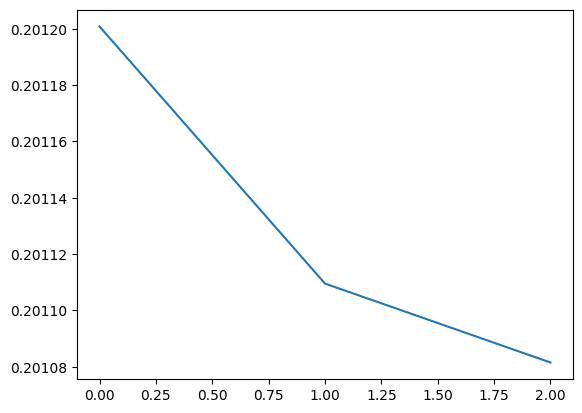

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.show()

In [ ]:
# Test load
checkpoint = torch.load(f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_0.pth')
multimodal.load_state_dict(checkpoint['model_state_dict'])

KeyboardInterrupt: ignored

In [ ]:
torch.save({'model_state_dict': multimodal.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'epoch': i
      }, f'/content/drive/MyDrive/WebAI/Model Weights/CCNeT5_OffLine1/CCNeT5_{0}_sampled_combined_loss_bigger.pth')

In [ ]:
#best_combined_loss = train_loss + epoch_loss
best_combined_loss

6.505355464400597

# Make some inference

In [ ]:
def make_inference(model, rgb_input, language_input, previous_action_input, t5_output):

    rgb_rgb_input_data = rgb_input.to(device)
    language_input = language_input.to(device)
    print(rgb_rgb_input_data.dtype, language_input.dtype, previous_action_input.dtype, t5_output.dtype)

    action_output = model.forward(rgb_rgb_input_data, language_input, previous_action_input, t5_output)

    print(f'action_output: {action_output.shape} - {action_output.dtype}')

    return action_output

In [ ]:
# /!\ Note: this inference test is for the first offline training only (regarding T5 outputs)

for rgb_data, language_data, previous_action, t5_output in zip(train_batched_rgb, train_batched_language, train_batched_previous_actions, train_batched_labels):
  print(f'T5 Output is: {t5_output}')
  prediction = make_inference(multimodal, rgb_data, language_data, previous_action, t5_output)
  break

T5 Output is: tensor([[ 0.0000, -0.1927,  1.3373,  ...,  0.7378, -1.3595,  0.6771],
        [ 0.0000, -0.5229,  2.6772,  ...,  0.7378, -1.3595,  0.6771],
        [ 0.0000, -0.7171, -1.6297,  ...,  0.7378, -1.3595,  0.6771],
        ...,
        [ 0.0000, -0.8374, -1.0608,  ...,  0.7378, -1.3595,  0.6771],
        [ 0.0000, -0.2081, -0.1262,  ...,  0.7378, -1.3595,  0.6771],
        [ 0.0000, -0.4548, -1.2342,  ...,  0.7378, -1.3595,  0.6771]],
       device='cuda:0')
torch.float32 torch.float32 torch.float64 torch.float32
action_output: torch.Size([12, 577]) - torch.float32


In [ ]:
t5_output[0, 1:65].shape

torch.Size([64])

In [ ]:
previous_ac_test = train_formatted_previous_actions[0]

In [ ]:
keydown_tensor.shape, train_language_input[0].shape

(torch.Size([8, 64]), torch.Size([512, 64]))

In [ ]:
prediction.shape

torch.Size([12, 577])

In [ ]:
action_tensor = prediction[0, 0:1].to('cpu')  # First value
ref_tensor = prediction[1, 1:65].to('cpu')#.view(1, 64)  # Values from 2 to 64
keydown_tensor = prediction[0, 65:].view(8, 64).to('cpu')
action_tensor.shape, ref_tensor.shape, keydown_tensor.shape

(torch.Size([1]), torch.Size([64]), torch.Size([8, 64]))

In [ ]:
action_tensor, ref_tensor

(tensor([-68.3524], grad_fn=<ToCopyBackward0>),
 tensor([-0.2766,  0.0838,  0.1784,  0.3778,  0.6309, -0.4967,  0.1847,  0.0640,
          0.1040,  0.5652, -0.3048, -0.1451, -0.0790,  0.1988, -0.0561, -0.4480,
          0.0573, -0.2467, -0.0757,  0.2540,  0.1745,  0.2315,  0.1514, -0.4008,
          0.1049,  0.0163, -0.0409, -0.3582,  0.3988,  0.0908,  0.0246,  0.1666,
         -0.2936, -0.0569, -0.3968, -0.3193, -0.2483, -0.1293,  0.0546,  0.1712,
         -0.0207,  0.0807,  0.2888,  0.1942, -0.3423, -0.1275,  0.0692,  0.4485,
          0.5114, -0.5840,  0.0908, -0.5420, -0.2417, -0.0655, -0.1999,  0.2256,
         -0.1909, -0.0088, -0.3517,  0.1997, -0.2204,  0.2385,  0.0615,  0.3039],
        grad_fn=<ToCopyBackward0>))

In [ ]:
def get_embedding_index_t(x):
    results = torch.where(torch.sum((tokenizer.embedding_fn.embedding.weight == x), axis=1))
    #print(x.shape)
    if len(results[0]) == len(x):
        print(f'normal {results[0]}')
        return None
    else:
        #print(f'results: {results}')
        return results[0]

def get_tokens_from_embeddings_t(tokenizer, embedded_tokens):
    #indices = torch.Tensor(list(map(get_embedding_index_t, embedded_tokens)))
    indices = []
    for em in embedded_tokens:
      indices.append(em)
    print(indices)
    indices = indices[0]

    #print(indices.shape)
    #indices = torch.Tensor(list(map(get_embedding_index_t, tokenizer, embedded_tokens)))
    return indices

In [ ]:
t = get_tokens_from_embeddings_t(tokenizer, ref_tensor)
print(t.shape)
tokenizer.detokenize_array(t)

[tensor(-0.2766, grad_fn=<UnbindBackward0>), tensor(0.0838, grad_fn=<UnbindBackward0>), tensor(0.1784, grad_fn=<UnbindBackward0>), tensor(0.3778, grad_fn=<UnbindBackward0>), tensor(0.6309, grad_fn=<UnbindBackward0>), tensor(-0.4967, grad_fn=<UnbindBackward0>), tensor(0.1847, grad_fn=<UnbindBackward0>), tensor(0.0640, grad_fn=<UnbindBackward0>), tensor(0.1040, grad_fn=<UnbindBackward0>), tensor(0.5652, grad_fn=<UnbindBackward0>), tensor(-0.3048, grad_fn=<UnbindBackward0>), tensor(-0.1451, grad_fn=<UnbindBackward0>), tensor(-0.0790, grad_fn=<UnbindBackward0>), tensor(0.1988, grad_fn=<UnbindBackward0>), tensor(-0.0561, grad_fn=<UnbindBackward0>), tensor(-0.4480, grad_fn=<UnbindBackward0>), tensor(0.0573, grad_fn=<UnbindBackward0>), tensor(-0.2467, grad_fn=<UnbindBackward0>), tensor(-0.0757, grad_fn=<UnbindBackward0>), tensor(0.2540, grad_fn=<UnbindBackward0>), tensor(0.1745, grad_fn=<UnbindBackward0>), tensor(0.2315, grad_fn=<UnbindBackward0>), tensor(0.1514, grad_fn=<UnbindBackward0>), t

TypeError: ignored

In [ ]:
t = get_tokens_from_embeddings_t(tokenizer, train_language_input[0])
tokenizer.detokenize_array(t)

NameError: ignored

In [ ]:
keydown_tensor.shape, train_language_input[0][:8, :].shape

(torch.Size([8, 64]), torch.Size([8, 64]))

In [ ]:
t1 = tokenizer.get_tokens_from_embeddings(train_language_input[0][:8, :])
print(t1.shape)
tokenizer.detokenize_array(t1)

torch.Size([8])


'<body left 0 top 0 width 840 height '

In [ ]:
train_language_input[0].shape, train_language_input[0].dtype

(torch.Size([512, 64]), torch.float32)

In [ ]:
keydown_tensor.shape, keydown_tensor.dtype

(torch.Size([8, 64]), torch.float32)

In [ ]:
train_language_input[0].shape

torch.Size([512, 64])

In [ ]:
torch.save(tokenizer.embedding_fn.state_dict(), '/content/drive/MyDrive/WebAI/Configs/embedding_weights.pth')

In [ ]:
tokenizer_2 = tokenizer
tokenizer_2.embedding_fn.load_state_dict(torch.load('/content/drive/MyDrive/WebAI/Configs/embedding_weights.pth'))

<All keys matched successfully>

In [ ]:
tokenizer_2.detokenize_array(tokenizer_2.get_tokens_from_embeddings(train_language_input[0]))

'<body left 0 top 0 width 1260 height 210 id classes ref 83 children <div left 0 top 0 width 160 height 210 id wrap classes ref 33 children <div left 0 top 50 width 160 height 160 id area classes ref 37 children <div left 0 top 50 width 160 height 150 id reply classes ref 71 children <div left 0 top 50 width 160 height 20 id reply - bar classes ref 65 children <span left 0 top 60 width 10 height 10 id close - reply classes ref 99 text children </span> <span left 140 top 60 width 10 height 10 id send - reply classes ref 122 text children </span> </div> <div left 0 top 70 width 160 height 30 id classes reply - header ref 101 children <div left 0 top 70 width 160 height 20 id classes reply - info ref 19 children <label left 0 top 80 width 20 height 10 id classes reply - to ref 12 text to: children </label> <span left 20 top 80 width 30 height 10 id classes reply - sender ref 92 text Dorette children </span> </div> <div left 0 top 90 width 160 height 20 id classes reply - subject ref 55 ch

In [ ]:
test_encode = tokenizer.

# Find closest embedding to retrieve our values

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_embedding(input_embedding, embedding_matrix):
    """
    Finds the index of the closest match to the input embedding based on cosine similarity.

    Args:
        input_embedding (np.ndarray): Array of shape (8,) representing the input embedding.
        embedding_matrix (np.ndarray): Array of shape (10, 8) representing the embedding matrix.

    Returns:
        int: Index of the closest match to the input embedding.
    """
    # Normalize input embedding for cosine similarity
    input_embedding_norm = input_embedding / np.linalg.norm(input_embedding)

    # Normalize embedding matrix for cosine similarity
    embedding_matrix_norm = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)

    # Calculate cosine similarity between input embedding and embedding matrix
    similarity_scores = cosine_similarity(input_embedding_norm.reshape(1, -1), embedding_matrix_norm)

    # Find the index of the closest match
    closest_index = np.argmax(similarity_scores)

    return closest_index

In [ ]:
with torch.no_grad():
  output_embedding = t5_output[0, 1:65].to('cpu').numpy()
  embedding_matrix = tokenizer.embedding_fn.embedding.weight.detach().numpy()  # Your embedding matrix of shape (10, 8)
  closest_index = find_closest_embedding(output_embedding, embedding_matrix)
  print(f'closest_index: {closest_index}')
  print(tokenizer.itos[closest_index])

closest_index: 169
144


NameError: ignored